In [1]:
import warnings
warnings.filterwarnings("ignore")

# Spatial Inequality



In [2]:
import seaborn
import pandas
import geopandas
import pysal
import numpy
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import inequality
from pysal.explore import esda
from pysal.lib import weights

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5


## Introduction

This chapter uses economic inequality to illustrate how the study of the evolution of social 
disparities can benefit from an explicitly spatial treatment.
Social and economic inequality is often at the top of policy makers' agendas.
Its study has always drawn considerable attention in academic circles.
Much of the focus has been on *interpersonal income inequality*, yet there is a growing recognition
that the question of *inter-regional income inequality* requires further 
attention as the growing gaps between poor and rich regions have been identified
as key drivers of civil unreset {cite}`ezcurra2019` and  political polarization in developing and developed countries
{cite}`Rodriguez_Pose_2018`.

Much of the study of inequalities has focused at the individual level: how do outcomes
differ across individuals? This approach does not group individuals geographically. 
In other words, it is not concerned with whether those differences follow a pattern,
for example, at the regional level (e.g., *is most of the more disadvantaged population
located in a particular section of the map?*).
Indeed, while the two literatures (personal and regional inequality) are
related, they have developed in a largely parallel fashion with limited
cross-fertilization. In this chapter, we examine how a spatially explicit focus
can provide insights on the study of inequality and its dynamics. We hope this illustration
can be useful in itself but also inspire the use of these methods in the study of
other phenomena for which the regional perspective can bring value to the table.

After discussing the data we employ, we begin with an introduction to classic methods for interpersonal income
inequality analysis and how they have been adopted to the question of regional
inequalities. These include a number of graphical tools along side familiar
indices of inequality. As we discuss more fully, the use of these classical
methods in spatially referenced data, while useful in providing insights on some
of the aspects of spatial inequality, fails to fully capture the nature of
geographical disparities and their dynamics. Thus, we next move to spatially
explicit measures for regional inequality analysis. The chapter closes with
some recent extensions of some classical measures to more fully examine the
spatial dimensions of regional inequality dynamics.




## Data: US State Per Capita Income 1969-2017

The data used in this chapter contain repeated measurements for geographic regions over time.
We consider the United States from 1969 to 2017; specifically, we will analyze median incomes at the county level. This perspective will allow to examine trends both in terms of how individual counties, states, or regions get richer or poorer, as well as how the overall distribution of income moves, skews, or spreads out. 


In [3]:
pci_df = geopandas.read_file('../data/us_county_income/uscountypcincome.gpkg')
pci_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

Inspection of the column names reveals that the table is organized around one row per county, and with the years as columns, together with information about the particular record.
This format is an example of a [*wide* longitudinal data set](https://en.wikipedia.org/wiki/Wide_and_narrow_data).
In wide-format data, each column represents a different time period, meaning that each row represents a set of measurements made about the same "entity" over time (as well as any unique identifying information about that entity.)
This contrasts with a *narrow* or *long* format, where each row describes an entity at a specific point in time. 
Long data results in significant duplication for records and is generally worse for data storage, particularly in the geographic case. However, long form data is sometimes a more useful format when manipulating and analyzing data, as {cite}`wickham2014tidy` discusses. Nonetheless, when analyzing *trajectories*, that is, the paths that entities take over time, wide data is more useful, and we will use that here. 

In this data, we have 3076 counties across 49 years, as well as 28 extra columns that describe each county. 
<!-- 
ljw: we (1) don't discuss wide vs. long anywhere else in the book and (2) don't ever show a wide-to-long pivot using something like pandas.wide_to_long... We also don't need the LineCode filtering, since the final dataframe is already filtered by LineCode so that all LineCode==3.

dab: 
- On (1), I'd say that's OK, as we have it now still feels useful and not too out of context. I think (2) would be good but I don't see it as a crucial USP of the book.
- do we need the 28 extra columns if the analysis is univariate? If not, I'd vote to remote them to slim down the data footprint.
-->


In [4]:
pci_df.shape

(3076, 77)

As an example, we can see the first few years for Jackson County, Mississippi (state code `28`) below:

In [5]:
pci_df.query('NAME == "Jackson" & STATEFP == "28"')

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2012,2013,2014,2015,2016,2017,index,IndustryCl,Descript_1,geometry
1417,28,059,00695753,28059,Jackson,Jackson County,06,H1,G4020,None,...,34586,34494,34905,35429,35890,36449,NaN,None,None,"POLYGON ((-88.82351 30.38205, -88.88453 30.677..."


## Global Inequality

We begin our examination of inequality by focusing on several global measures of income inequality. Here, "global" means that the measure is concerned with the overall nature of inequality within the income distribution. That is, these measures focus on the direct disparity between rich and poor, considering nothing about where the rich and poor live. Several classic measures of inequality are available for this purpose. 

In general terms, measures of inequality focus on the dispersion present in an income distribution. In the case of regional or spatial inequality, the distributions describe the average or per capita incomes for spatial units, such as for counties, census tracts, or regions. For our US county data, we can visualize the distribution of per capita incomes for the first year in the sample as follows:

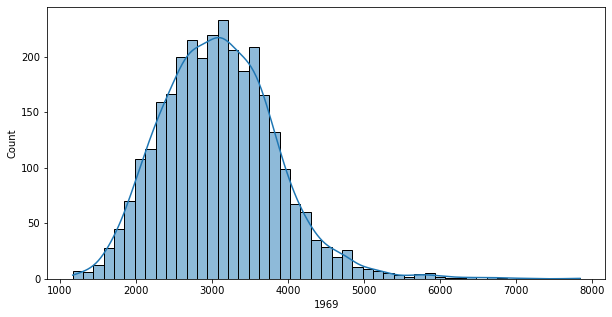

In [6]:
seaborn.histplot(x=pci_df['1969'], kde=True);

Looking at this distribution, notice that the right side of the distribution is much longer than the left side. This long right tail is a prominent feature, and is common in the study of incomes and many other societal phenomena, as it reflects the fact that within a single income distribution, the super-rich are generally much more wealthy than the super-poor are deprived, compared to the average. 

A key point to keep in mind here is that the unit of measurement in this data is a spatial aggregate of individual incomes. Here, we are using the per capita incomes for each county. By contrast, in the wider inequality literature, the observational unit is typically a household or individual. In the latter distributions, the degree of skewness is often more pronounced. This difference arises from the smoothing that is intrinsic to aggregation: the regional distributions are based on averages obtained from the individual distributions, and so the extremely high-income individuals are averaged with the rest of their county. The regional approach implies that, to avoid falling into the so-called "ecological fallacy", whereby individual conclusions are drawn from geographical aggregates, our conclusions will hold at the area level (the *county*) rather than the individual one (the *person*).

The kernel density estimate (or histogram) is a powerful visualization device that captures the overall morphology of the *feature* distribution for this measure of income. At the same time, the plot is silent on the underlying *geographic distribution* of county incomes. We can look at this second view of the distribution using a choropleth map. To construct this, we can use the standard `geopandas` plotting tools. 

Before we can get to mapping, we note the data is expressed in longitude and latitude but this is *not* recorded on `pci_df`. We set the CRS explicitly and then change it to one more suitable for mapping, the Albers Equal Area projection for North America:  

In [7]:
pci_df = (pci_df.set_crs(epsg=4326) # US Census default projection
                .to_crs(epsg=5070)) # Albers Equal Area North America

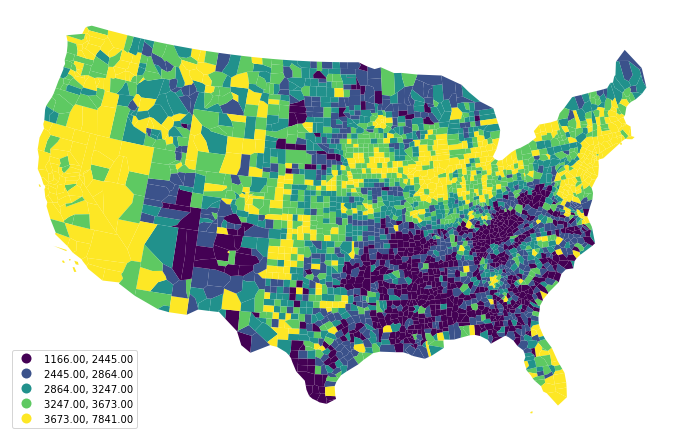

In [8]:
ax = pci_df.plot(
    column='1969', 
    scheme='Quantiles', 
    legend=True, 
    edgecolor='none',
    legend_kwds={'loc': 'lower left'}, 
    figsize=(12, 12)
)
ax.set_axis_off()
plt.show()

The choropleth and the kernel density provide different visual depictions of the distribution of county incomes. The kernel density estimate is a *feature*-based representation, and the map is a *geographic* representation. Both are useful for developing a more comprehensive understanding. To gain insights on the level of inequality in the distribution, we'll discuss a few indices common in the statistical and econometric literatures. 

### 20:20 Ratio

One commonly used measure of inequality in a distribution is the so called 20:20 ratio, which is defined as the ratio of the incomes at the 80th percentile over that at the 20th percentile: 
<!-- #endregion -->

In [9]:
top20, bottom20 = pci_df['1969'].quantile([.8, .2])

In [10]:
top20/bottom20

1.5022494887525562

In 1969 the richest 20% of the counties had an income that was 1.5 times the poorest 20% of the counties. The 20:20 ratio has the advantage of being robust to outliers at the top and the bottom of the distribution. To look at the dynamics of this global inequality measure, one way is to create a function that calculates it for a given year, and apply it to all years in our time series:

In [11]:
def ineq_20_20(values):
    top20, bottom20 = values.quantile([.8, .2])
    return top20 / bottom20

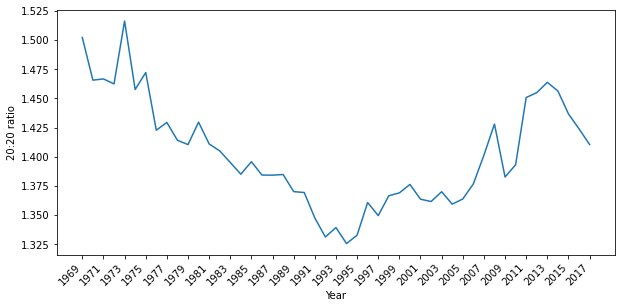

In [12]:
years = numpy.arange(1969, 2018).astype(str)
ratio_2020 = pci_df[years].apply(ineq_20_20, axis=0)
ax = plt.plot(years, ratio_2020)

figure = plt.gcf()
plt.xticks(years[::2])
plt.ylabel("20:20 ratio")
plt.xlabel("Year")
figure.autofmt_xdate(rotation=45)

plt.show()

The evolution of the ratio has a U-shaped pattern over time, bottoming out around 1994 after a long decline. Post 1994, however, the 20:20 ratio indicates there is increasing inequality up until 2013, where there is a turn towards lower income inequality between the counties.

In addition to the 20/20 ratio, we will explore two more traditional measures of inequality: the Gini and Theil's indices. For these, we will use the `inequality` package from `pysal`.

### Gini Index

The Gini index is a longstanding measure of inequality based on the notion of cumulative wealth distribution. To construct a Lorenz curve, the cumulative share of wealth is plotted against the share of the population that owns that wealth. For example, in an extremely unequal society where few people own nearly all the wealth, the Lorenz curve increases very slowly at first, then skyrockets once the wealthiest people are included. 

In contrast, a "perfectly equal" society would look like a straight line connecting $(0,0)$ and $(1,1)$. This is called the *line of perfect equality*, and represents the case where $p$% of the population owns exactly $p$% of the wealth. For example, this might mean that 50% of the population earns exactly 50% of the income, or 90% of the population owns 90% of the wealth. The main idea is that the share of wealth or income is exactly proportional to the share of population that owns that wealth or earns that income, which occurs only when everyone has the same income or owns the same amount of wealth. 

With these notions in mind, we can define the Gini index as the ratio of the area between the line of perfect equality and the Lorenz curve for a given income or wealth distribution, standardized by the area under the line of perfect equality (which is always $\frac{1}{2}$). Thus, the Gini index is a measure of the gap between a perfectly equal society and the observed society over every level of wealth/income. 

We can construct one of the Lorenz curves for 1969 by first computing the share of our population of counties that is below each observation. For that, we generate a cumulative series:

In [13]:
n = len(pci_df)
share_of_population = numpy.arange(1, n+1) / n

Then, we consider the cumulative evolution of income. For this, we need to find out the proportion of total income that owned by each share of the population. Empirically, this can be computed in the following fashion. First, we sort county incomes:

In [14]:
incomes = pci_df['1969'].sort_values()

Second, we find the overall percentage of income accumulated at each data point. To do this, we compute what percentage of the total income that of each county represents:

In [15]:
shares = incomes / incomes.sum()

and construct the *cumulative sum* of these shares, which reflects the sum of all of the shares of income up to the current one:

$$ \texttt{CumSum(v, k)} = \sum_{i=1}^k v_i$$

This starts at $0$ and reaches $1$ once the last share is included:

In [16]:
cumulative_share = shares.cumsum()

With this, we can plot both the Lorenz curve and the line of perfect equality:

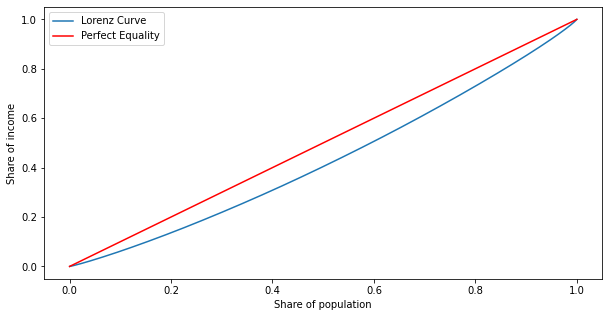

In [17]:
f, ax = plt.subplots()
ax.plot(share_of_population, cumulative_share, label='Lorenz Curve')
ax.plot((0,1), (0,1), color='r', label='Perfect Equality')
ax.set_xlabel('Share of population')
ax.set_ylabel('Share of income')
ax.legend()
plt.show()

The blue line is the Lorenz curve for county incomes in 1969. The Gini index is the area between it and the 45-degree line of equality shown in red, all standardized by the area underneath the line of equality.

A first approach to examine how inequality has evolved is to plot the Lorenz curves for each year. One way to do this in Python involves creating a function that will compute the Lorenz curve for an arbitrary set of incomes. The following function encapsulates the steps shown above into a single shot:

In [18]:
def lorenz(y):
    y = numpy.asarray(y)
    incomes = numpy.sort(y)
    income_shares = (incomes / incomes.sum()).cumsum()
    N = y.shape[0]
    pop_shares = numpy.arange(1, N+1)/N
    return pop_shares, income_shares

We can use the same strategy as above to calculate the Lorenz curves for all the years in our datasets:

In [19]:
lorenz_curves = pci_df[years].apply(lorenz, axis=0)

Practically, this becomes a dataframe with columns for each year. Rows contain the population shares (or income shares) as lists.

In [20]:
lorenz_curves.head()

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...",...,"[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553..."
1,"[0.00012248644113964493, 0.0002529565611185806...","[0.00013470713147942766, 0.0002749742242147042...","[0.00013565871276465116, 0.0002735829350945102...","[0.000138851418132282, 0.0002856978062862818, ...","[0.00013772329900895125, 0.0002789403397482158...","[0.00013670247958589532, 0.0002822671421734887...","[0.00013545577965044458, 0.0002969630997663923...","[0.00013285409901160207, 0.0002894117453533050...","[0.0001243028615204895, 0.00025562579972132935...","[0.00012461982501385657, 0.0002617767612857009...",...,"[0.00014337413757142982, 0.0002952111969255050...","[0.0001456829143536576, 0.00030689603606708245...","[0.00014395847223286045, 0.000300079481701999,...","[0.00014303960415837748, 0.0002879780824635754...","[0.00014868735880996665, 0.0003029537221659007...","[0.00014777376351708422, 0.0002978443977606638...","[0.00011563121829018938, 0.0002592947418121832...","[0.00010564770915523224, 0.0002539806359455832...","[0.00014203484354254357, 0.0002909593179418555...","[9.276898012960255e-05, 0.0002421381514532987,..."


By iterating over the columns of this dataframe, we can make a plot of the Lorenz curves for each year:

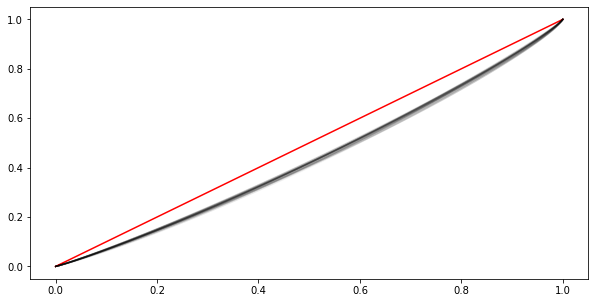

In [21]:
f, ax = plt.subplots()
ax.plot((0,1),(0,1), color='r')
for year in lorenz_curves.columns:
    year_pop_shares, year_inc_shares = lorenz_curves[year].values
    ax.plot(year_pop_shares, year_inc_shares, color='k', alpha=.05)

The compression of the Lorenz curves makes it difficult to ascertain the temporal pattern in inequality. Focusing explicitly on the Gini coefficients may shed more light on the evolution of inequality over time. 

Remember the Gini coefficient represents the area in between the Lorenz curve and that of perfect equality. The measure can be calculated directly through the `Gini` class in `inequality`. For 1969, this implies:

In [22]:
g69 = inequality.gini.Gini(pci_df['1969'].values)

To extract the coefficient, we retrieve the `g` property of `g69`:

In [23]:
g69.g

0.13556175504269904

Here, the Gini coefficient in 1969 was 0.13. To compute this for every year, we can use a similar pattern as we have before. First, define a function to compute the quantity of interest; then, apply the function across the table with all years:

In [24]:
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

PySAL's Gini requires an `numpy.ndarray` rather than a `pandas.Series` object, which we can pull out through the `values` attribute. This is passed to the `Gini` class, and we only return the value of the coefficient.

In [25]:
inequalities = pci_df[years].apply(gini_by_col, axis=0).to_frame('gini')

This results in a series of Gini values, one for each year:

In [26]:
inequalities.head()

,gini
1969,0.135562
1970,0.130076
1971,0.128540
1972,0.129126
1973,0.142166


Which we can turn into a graphical representation through standard `pandas` plotting. The resulting pattern is similar to that of the 20:20 ratio above:

<AxesSubplot:>

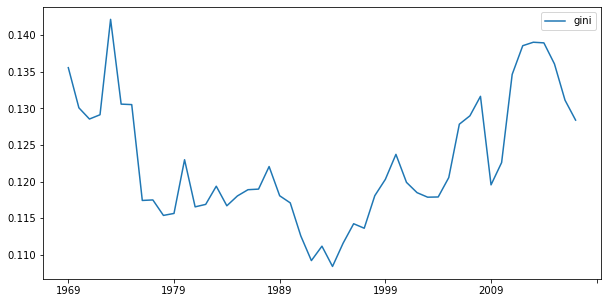

In [27]:
_ = _inequalities.plot()

### Theil's index

A third commonly used measure of inequality is Theil's $T$ given as:

$$T = \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right)$$

where $y_i$ is per capita income in area $i$ among $m$ areas. Conceptually, this metric is related to the entropy of the income distribution, measuring how evenly-distributed incomes are across the population.

The Theil index is also available in PySAL's `inequality`, so we can take a similar approach as above to calculate it for every year:

In [28]:
def theil(column):
    return inequality.theil.Theil(column.values).T

In [29]:
inequalities['theil'] = pci_df[years].apply(theil, axis=0)

And generate a visual comparison of the evolution of both Gini and Theil's indices:

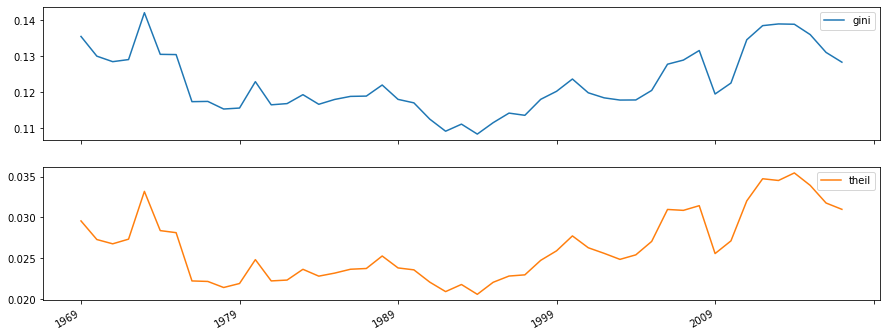

In [30]:
_ = inequalities.plot(subplots=True, figsize=(15,6))

The time paths of the Gini and the Theil coefficients show striking
similarities. At first glance, this might suggest that the indices are
substitutes for one another. However, they are not perfectly correlated: 

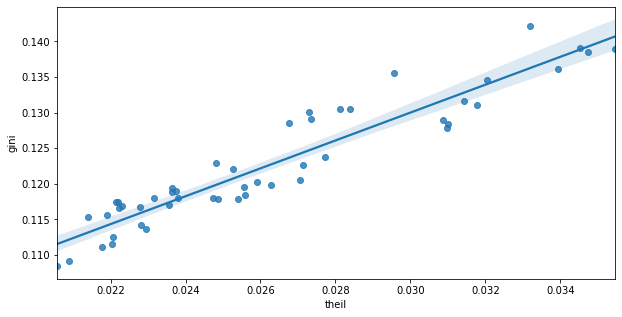

In [31]:
_ = seaborn.regplot(x='theil', y='gini', data=inequalities)

Indeed, as we shall see below, each index has
properties that lend themselves to particular spatial extensions that work in complementary ways. We need both (and more) for a complete picture. 



## Personal versus Regional Income
There is a subtle but important distinction between the study of personal and
regional income inequality. To see this, we first need to express the
relationships between the two types of inequality. Consider a country composed
of $N$ individuals who are distributed over $m$ regions. Let $Y_l$ denote the
income of individual $l$. Total personal income in region $i$ is given as $Y_i =
\sum_{l \in i} Y_l$. per capita income in region $i$ is $y_i = \frac{Y_i}{N_i}$,
where $N_i$ is the number of individuals in region $i$.

At the national level,  the coefficient of variation in incomes could be used as an index of interpersonal income inequality. This would be:

$$CV_{nat} = \sqrt{\frac{\sum_{l=1}^N (Y_l - \bar{y})^2}{N}}$$

where $\bar{y}$ is the national average for per capita income. The key component here is the sum
of squares term, and unpacking this sheds light on personal versus regional
inequality question:

$$TSS = \sum_{l=1}^N (Y_l - \bar{y})^2$$

An individual deviation, $\delta_l = Y_l - \bar{y}$, is the contribution to inequality associated with individual $l$. We can break this into two components:

$$\delta_l = (Y_l - y_i) +  (y_i - \bar{y})$$

The first term is the difference between the individual's income and per capita income in the individual's region of residence, while the second term is the difference between the region's per capita income and average national per capita income.

In regional studies, the intra-regional personal income distribution is typically
not available. As a result, the assumption is often made that intra-regional
personal inequality is zero. In other words, all individuals in the same region
have identical incomes. With this assumption in hand, the first term vanishes:
$Y_l -y_i = 0$, leading to:[^reg] 

[^reg]: It should also be noted that even at the national scale, the analysis of interpersonal income inequality also relies on aggregate data grouping individuals into income cohorts. See, for example, {cite}`Piketty_2003`.

$$
\begin{aligned}
TSS &= \sum_{l=1}^N (Y_l - \bar{y})^2 \\
    &= \sum_{l=1}^N \delta_l^2 \\
    &= \sum_{l=1}^N ((Y_l - y_i) +  (y_i - \bar{y}))^2 \\
    &= \sum_{l=1}^N (0 +  (y_i - \bar{y}))^2 \\
    &= \sum_{i=1}^m\sum_{l \in i}  (y_i - \bar{y})^2 \\
    &= \sum_{i=1}^m  [N_i(y_i - \bar{y})]^2
\end{aligned}
$$

This means that each individual in a region has an equal contribution to the
overall level of national interpersonal inequality, given by $(y_i - \bar{y})$,
while the region in question contributes $N_i(y_i - \bar{y})$. While it may seem
that the assumption of zero intra-regional interpersonal income inequality is
overly restrictive, it serves to isolate the nature of inter-regional income
inequality. That is, inequality between places, rather than inequality between
people within those places. In essence, this strategy shifts the question up one
level in the spatial hierarchy by aggregating micro-level individual data to
areal units.



## Spatial Inequality

The analysis of regional income inequality differs from the analysis of
national interpersonal income inequality in its focus on spatial units. Since
regional incomes are explicitly embedded in geographical space, we can take advantage
of their spatial configuration to learn more about the nature of the inequality.
In the regional inequality literature this has been approached in a number of ways.
Three are considered in this chapter: one that links the discussion to that of spatial
autocorrelation in chapters [6](06_spatial_autocorrelation) and [7](07_local_autocorrelation);
a second one based on decomposing global indices regionally; and a third one that embeds space
in traditional global measures.

### Spatial Autocorrelation



This approach helps us shed light on the properties of the spatial pattern of regional income data. We return to global measures of spatial autocorrelation that we encountered earlier in the book. The essence of this approach is to examine to what extent the spatial distribution of incomes is concentrated over space. For this, we use a queen spatial weights matrix and calculate Moran's I for
each year in the sample:

In [32]:
wq = weights.Queen.from_dataframe(pci_df)

Following the same pattern to "broadcast" a function, we create a function that returns the results we need from each statistic. Here, we will also keep the pseudo $p$-value for the Moran statistic which, as we saw in [Chapter 6](06_spatial_autocorrelation), helps us identify whether the index is statistically significant under the null hypothesis that incomes are randomly distributed geographically.

In [33]:
def moran_by_col(y, w=wq):
    mo = esda.Moran(y, w=w)
    mo_s = pandas.Series(
        {"I": mo.I, "I-P value": mo.p_sim},
    )
    return mo_s

This time, our function returns a `Series` object so that we pass it through `apply`, we get a well formatted table:

In [34]:
moran_stats = pci_df[years].apply(moran_by_col, axis=0).T

In [35]:
moran_stats.head()

,I,I-P value
1969,0.649090,0.001
1970,0.647438,0.001
1971,0.626546,0.001
1972,0.606760,0.001
1973,0.640226,0.001


For further comparison, the results are attached to the `inequalities` table:

In [36]:
inequalities = inequalities.join(moran_stats)

To show the overall inter-relationships between these statistics, we make another plot below:

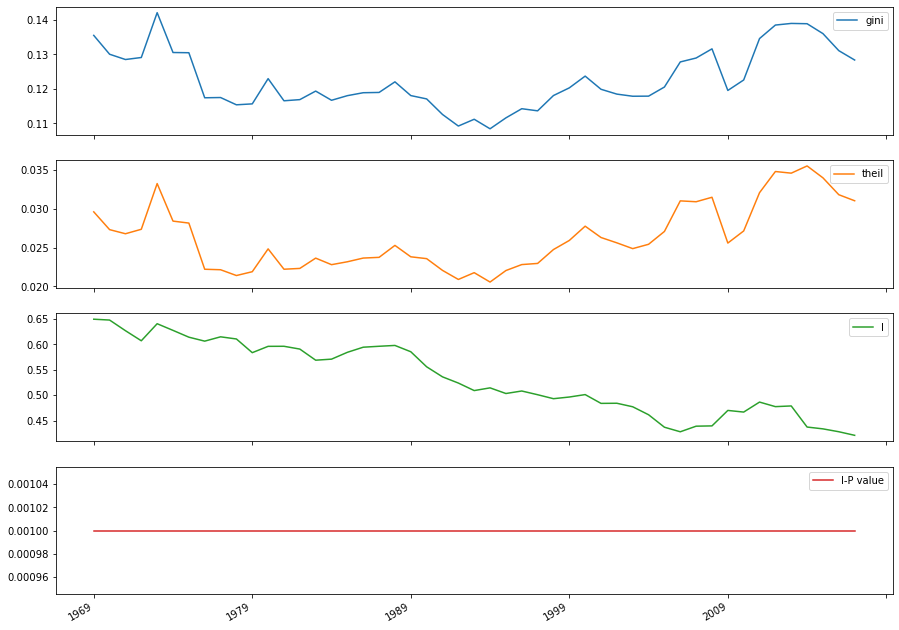

In [37]:
inequalities.plot(subplots=True, figsize=(15,12))
plt.show()

Several patterns emerge from the time series of Moran's I. Before delving into the details, it is worth noting that, while Gini and Theil follow a similar path, Moran's I displays a distinct trajectory. There is a long-term decline in the value of Moran's I. This suggests a gradual decline in the geographic structure of inequality with two implications: (a) per capita incomes are now less similar between nearby counties and (b), this has been consistently declining, regardless of whether inequality is high or low. 
Second, despite this decline, there is never a year in which the spatial autocorrelation is not statistically significant. In other words, there is a strong geographic structure in the distribution of regional incomes that needs to be accounted for when focusing on inequality questions.

### Regional Decomposition of Inequality

One common objection to the analysis of inequality in aggregate relates to lack of detail about the scale at which inequality is most important. Inequality can be driven by differences between groups and not by discrepancies in income between similar individuals. That is, there is always the possibility that observed inequality can be "explained" by a confounding variate, such as age, sex, or education. For example, income differences between older and younger people can "explain" a large part of the societal inequality in wealth: older people have much longer to acquire experience, and thus are generally paid more for that experience. Younger people do not have as much experience, so young people (on average) have lower incomes than older people. 

To combat this issue, it is often useful to *decompose* inequality indices into constituent groups. This allows us to understand how much of inequality is driven by aggregate group differences and how much is driven by observation-level inequality. This also allows us to characterize how unequal each group is separately. In geographic applications, these groups are usually spatially defined, in that *regions* are contiguous geographic groups of observations. This section discusses regional inequality decompositions as a way to introduce geography into the study of inequality. 

Let's illustrate these ideas with our income dataset. The table records the United States Census Bureau region a county belongs to in the `Region` variable. These divide the country into eight regions, each assigned a number that relates to its name as specified below:

In [38]:
region_names = {
    1:"New England",
    2: "Mideast",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountain",
    8: "Far West"
}

We can visualize the regions with the names on the legend by first mapping the name to each region number, and then rendering a qualitative choropleth:

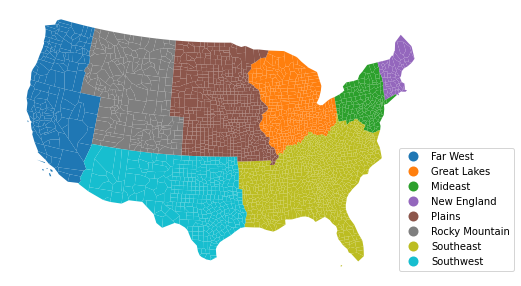

In [39]:
ax = pci_df.assign(Region_Name=pci_df.Region.map(region_names))\
      .plot(
    "Region_Name",
    linewidth=0,
    legend=True,
    categorical=True,
    legend_kwds=dict(bbox_to_anchor=(1.2,.5))
);
ax.set_axis_off()


Let's peak into income changes for each region. To do that, we can apply a split-apply-combine pattern that groups counties by region, calculates its mean, and combines it into a table:

In [40]:
rmeans = pci_df.assign(Region_Name=pci_df.Region.map(region_names))\
               .groupby(by='Region_Name')\
               .mean()\
               [years]

The resulting table has a row for each region and a column for each year. We can visualize these means to get a sense of their temporal trajectory:

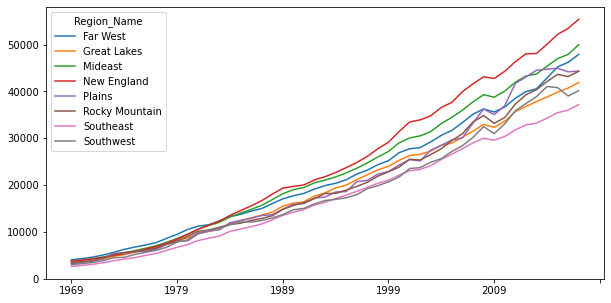

In [41]:
rmeans.T.plot.line();

One way to introduce geography into the analysis of inequality is to use geographical delineations to define groups for decompositions. For example, Theil's $T$, which we encountered previously, can be decomposed using regions into so called *between* and *within* regional inequality components.
To proceed in this direction, we first re-conceptualize our observations of per capita incomes for $m$ regional economies as $y = \left( y_1, y_2, \ldots, y_m \right)$. These are grouped into $\omega$ mutually exclusive regions. Formally, this means that when $m_g$ represents the number of areas assigned to region $g$, the total number of areas must be equal to the count of all the areas in each region: $\sum_{g=1}^{\omega} m_g=m$.[^mut-ex] With this notation, Theil's index from above can be rewritten to emphasize its between and within components:

[^mut-ex]: This would be violated, for example, if one area were in two regions. This area would get "double counted" in this total. 

$$
\begin{aligned}
T &= \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right) \\
  &= \left[ \sum_{g=1}^{\omega} s_{g} \ln \left(\frac{m}{m_g} s_g \right)  \right] + \left[ \sum_{g=1}^{\omega} s_g \sum_{i \in g} s_{i,g} \ln \left(m_g s_{i,g}\right) \right] \\
  &= B + W \\
\end{aligned}
$$

where $s_g = \frac{\sum_{i \in g} y_i}{\sum_i y_i}$, and   $s_{i,g} = y_i / \sum_{i \in g} y_i$. 

The first term is the between regions inequality component, and the second is
the within regions inequality component. The within regions term is a weighted
average of inequality between economies belonging to the same region. Similar
to what is done above for the case of interpersonal inequality, the estimate of
the between region (group) component of the decomposition is based on setting
the incomes of all economies (individuals) belonging to a region (group) equal
to that of the regional (group) average of these per capita incomes. Now,
however, intra-regional inequality between economies within the same region is
explicitly considered in the second component.[^weight]

[^weight]: The regional decomposition does not involve weighting the regions by their respective population. See  {cite}`Gluschenko_2018` for further details. 




Once we have covered the decomposition conceptually, the technical implementation is straightforward thanks to the `inequality` module of PySAL, and the `TheilD` class:

In [42]:
theil_dr = inequality.theil.TheilD(pci_df[years].values, pci_df.Region)

The `theil_dr` object has the between and within components stored in the `bg` and `wg` attributes. The `bg` stands for the "between" component, and "wg" for the within component. For example the "between" component for each year is computed is:

In [43]:
theil_dr.bg

array([0.00914353, 0.00822696, 0.00782675, 0.00768201, 0.01022634,
       0.0081274 , 0.00783943, 0.00572543, 0.00560271, 0.0054971 ,
       0.00511791, 0.00566001, 0.00486877, 0.00466134, 0.00474425,
       0.00424528, 0.00428434, 0.00453503, 0.00465829, 0.00456699,
       0.00467363, 0.00412391, 0.00366334, 0.00342112, 0.00327131,
       0.00312475, 0.00326071, 0.00359733, 0.00327591, 0.00363014,
       0.00382409, 0.00436261, 0.00399156, 0.00402506, 0.00397   ,
       0.00394649, 0.00353368, 0.00362698, 0.00400508, 0.00449814,
       0.0043533 , 0.00470988, 0.0063954 , 0.00642426, 0.00694236,
       0.00644971, 0.00591871, 0.00554072, 0.00528702])

If we store these components in our results table as we have been doing:

In [44]:
inequalities['theil_between'] = theil_dr.bg
inequalities['theil_within'] = theil_dr.wg
inequalities.drop('I-P value', axis=1, inplace=True)

We can visualize them alongside our earlier results:

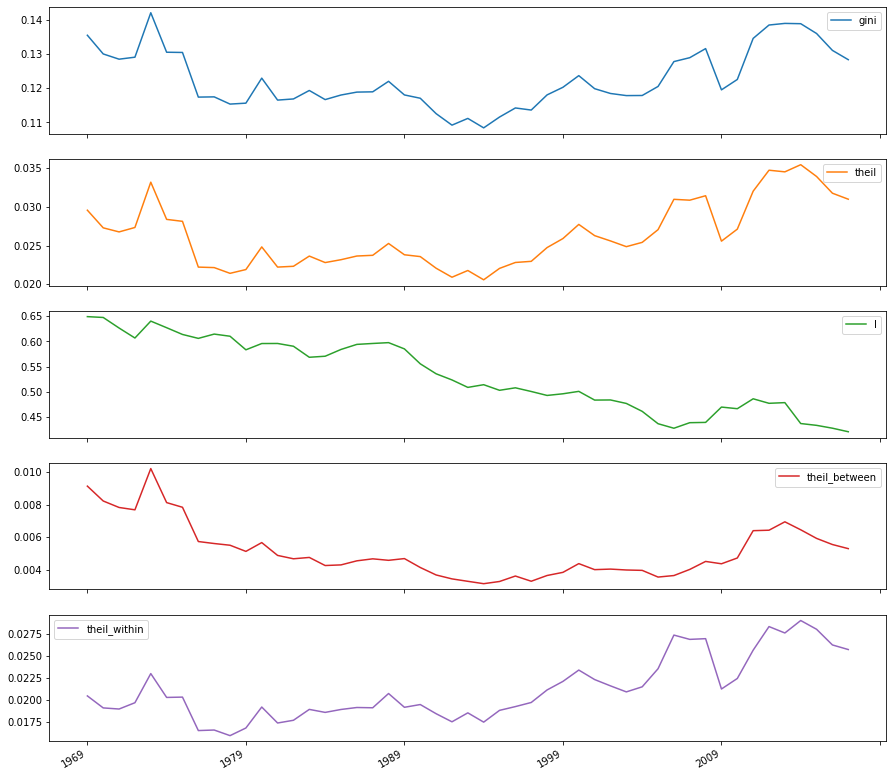

In [45]:
inequalities.plot(subplots=True, figsize=(15,15))
plt.show()

Inference on these decompositions can be done using the `inequality.theil.TheilDSim` class, but we omit that here for brevity and report that, like the Moran's $I$, all of the Theil decompositions are statistically significant. Further, since the within and between components are interpreted as shares of the overall Theil index, we can compute the share of the Theil index due to the between-region inequality, and note that it also generally shares the same pattern, but does not see minima in the same places:

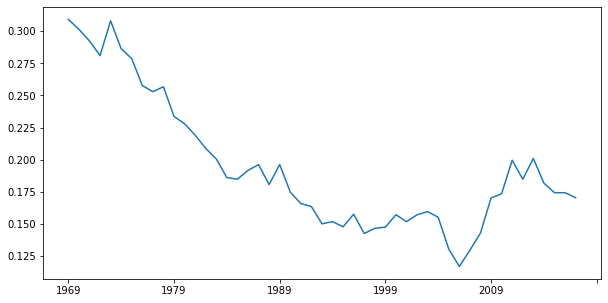

In [46]:
inequalities['theil_between_share'] = inequalities['theil_between'] / inequalities['theil']
inequalities['theil_between_share'].plot()
plt.show()

 The between-region share of inequality is at its lowest in the mid-2000s, not in the mid-1990s. This suggests that regional differences were very important in the 1970s and 1980s, but this importance has been waning, relative to the inequality *within* US Census Regions. 

<!-- #region {"ein.tags": "worksheet-0", "slideshow": {"slide_type": "-"}} -->


### Spatializing Classic Measures

While regional decompositions are useful, they do not tell the whole story. Indeed, a "region" is just a special kind of group; its "geography" is only made manifest through group membership (*is the county "in" the region or not?*). This kind of "place-based" thinking, while geographic, is not necessarily *spatial*. It does not incorporate the notions of distance or proximity into the study of inequality. The geographical locations of the regions could be re-arranged without impact, so long as the group membership structure is maintained. While, arguably, shuffling regions around means they are no longer "regions," the statistical methods would be no different. 

The final approach we review here is an explicit integration of space within traditional, non-spatial measure. In particular, we consider a *spatialized* version of the Gini coefficient, introduced by {cite}`Rey_2012`. The spatial Gini is designed to consider
the role of spatial adjacency in a decomposition of the traditional Gini. The original index can be formulated focusing on the set of pairwise absolute differences in incomes:

$$G = \frac{\sum_i \sum_j \left | y_i - y_j \right|}{2 n^2 \bar{x}} $$

Focusing on the set of pairwise absolute differences in income, we can de-compose this into the set of differences between "nearby" observations and the set of differences among "distant" observations. This is the main conceptual point of the "Spatial Gini" coefficient. This decomposition works similarly to the regional decomposition of the Theil index:

$$
\sum_i \sum_j \left |y_i - y_j \right | =\sum_i \sum_j \underset{\text{near differences}}{\left( w_{ij} \left |y_i - y_j \right | \right )} + \underset{\text{far differences}}{\left( (1-w_{ij})  \left |y_i - y_j \right | \right )}
$$

In this decomposition, $w_{ij}$ is a binary variable that is $1$ when $i$ and $j$ are neighbors, and is zero otherwise. Recalling the spatial weights matrices from Chapter 4, this can be used directly from a spatial weights matrix.^[However, non-binary spatial weights matrices require a correction factor, and are not discussed here.] Thus, with this decomposition, the Spatial Gini can be stated as

$$G = \frac{\sum_i \sum_j w_{i,j}\left | x_i - x_j \right|}{2 n^2 \bar{x}} +   \frac{\sum_i \sum_j \left (1-w_{i,j} )| x_i - x_j \right|}{2 n^2 \bar{x}}$$

with the first term being the component among neighbors and the second term being the component among non-neighbors. The "spatial Gini", then, is the first component that describes the differences between nearby observations. 

The spatial Gini allows for a consideration of spatial dependence in inequality. If spatial dependence is very strong and positive, incomes are very similar among nearby observations, so the inequality of "near" differences will be small. Most of the inequality in the society will be driven by disparities in income between distant places. In contrast, when dependence is very weak (or even negative), then the two components may equalize. Inference on the spatial Gini can be based on random spatial permutations of the income values, as we have seen elsewhere in this book. This tests whether the distribution of the components are different from that obtained when incomes are randomly distributed across the map. 

The spatial Gini also provides a useful complement to the regional decomposition used in the Theil statistic. The latter does not consider pairwise relationships between observations, while the spatial Gini does. By considering the pairwise relationships between observations, the Gini coefficient is more sensitive, and can also be more strongly affected by small groups of significantly wealthy observations.  

We can estimate spatial Gini coefficients using the `Gini_Spatial` class:

In [47]:
from inequality.gini import Gini_Spatial

First, since the spatial Gini requires binary spatial weights, we will ensure this is so before proceeding:

In [48]:
wq.transform = 'B'

Then, the spatial Gini can be computed from an income vector and the spatial weights describing adjacency among the observations. 

In [49]:
gs69 = Gini_Spatial(pci_df['1969'], wq)

The aspatial Gini is stored in the `g` attribute, just like for the aspatial class:

In [50]:
gs69.g

0.13556175504269904

The share of the overall Gini coefficient that is due to the "far" differences is stored in the `wcg` share:

In [51]:
gs69.wcg_share

0.13541750749645268

The $p$-value for this tests whether the component measuring inequality among neighbors is larger (or smaller) than that would have occurred if incomes were shuffled randomly around the map:

In [52]:
gs69.p_sim

0.01

The value is statistically significant for 1969, indicating that inequality between neighboring pairs of counties is different from the inequality between county pairs that are not geographically proximate.

We can apply the same statistic over each year in the sample using the function-by-column approach as before. In this case, we want to return the statistic itself, as well as the decomposition between variation in the neighbors and that for non-neighbors, and the pseudo P-values:

In [53]:
def gini_spatial_by_col(incomes, weights):
    gs = Gini_Spatial(incomes, weights)
    denom = 2 * incomes.mean() * weights.n**2
    near_diffs = gs.wg / denom
    far_diffs = gs.wcg / denom
    out = pandas.Series(
        {
            "gini": gs.g,
            "near_diffs": near_diffs,
            "far_diffs": far_diffs,
            "p_sim": gs.p_sim
        }
    )
    return out

Inference on this estimator is computationally demanding, since the pairwise differences have to be re-computed every permutation, so the following cell takes some time to complete execution: 

In [54]:
%%time
spatial_gini_results = pci_df[years].apply(gini_spatial_by_col, weights=wq).T

CPU times: user 2min 8s, sys: 87.3 ms, total: 2min 8s
Wall time: 2min 9s


In [55]:
spatial_gini_results.head()

,gini,near_diffs,far_diffs,p_sim
1969,0.135562,0.000144,0.135418,0.01
1970,0.130076,0.000141,0.129935,0.01
1971,0.128540,0.000142,0.128398,0.01
1972,0.129126,0.000140,0.128985,0.01
1973,0.142166,0.000145,0.142021,0.01


The $p$-values are always small, suggesting that the contribution of the local ties is always smaller than that that would be expected if incomes were distributed randomly in the map.^[While it is possible that the "near differences" component could be *larger* than expected, that would imply negative spatial dependence, which is generally rare in empirical work.] We can compute the percent of times the $p$-value is smaller than a threshold using the mean:

In [56]:
(spatial_gini_results.p_sim < 0.05).mean()

1.0

While it may appear that the component due to "near differences" is quite small, this has two reasons. First, the number of "nearby" pairs are less than 1% of all pairs of observations:

In [57]:
wq.pct_nonzero

0.19385366975502275

Second, when spatial dependence is high, nearby observations will be similar. So, each "near difference" will also be small. Adding together a small number of small observations will generally be small, relative to the large differences between distant observations. Thus, small values of the "near" distances are indicative of spatial dependence. Indeed, we can see that as the spatial dependence weakens, the `near_diffs` get larger:

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

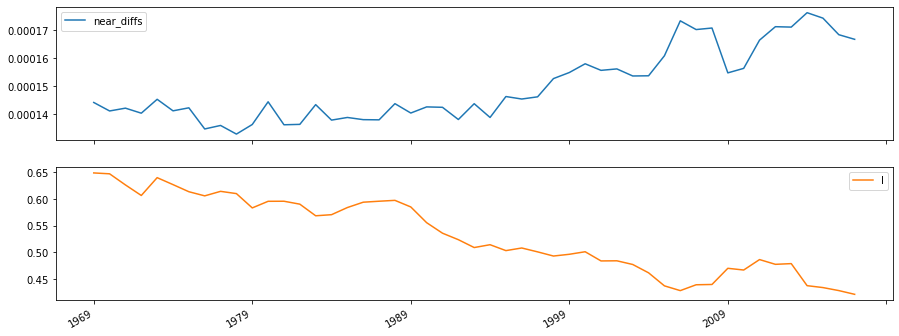

In [58]:
inequalities['near_diffs'] = spatial_gini_results.near_diffs

inequalities[['near_diffs', 'I']].plot.line(subplots=True, figsize=(15,6))

## Conclusion

Inequality is an important social phenomenon, and its geography is a growing concern for social scientists. Geographical disparities in well-being have been pointed to as a major driver behind the rise of right-wing populist movements in the US and Europe {cite}`Rodriguez_Pose_2018`. Thus, understanding the nature of these disparities and their evolution is a challenge for both science and policy.

This chapter discusses methods to assess inequality, as well as examine its spatial and regional structure. We have seen the Gini coefficient and Theil index as examples of global measures to summarize the overall level of inequality. As is often the case in many areas of spatial analysis, the straightforward adoption of methods from economics and sociology to spatial data can  often be fruitful but, at the same time, can miss key elements of the spatial story. In the context of spatial income disparities, we have highlighted the  differences between personal and regional inequality. From this vantage, we have reviewed three approaches to incorporate geography and space in the study of inequality. Together, this gives us a good sense of how inequality manifests geographically, and how it is (possibly) distinct from other kinds of spatial measures, such as those for spatial autocorrelation discussed in chapters [6](06_spatial_autocorrelation) and [7](07_local_autocorrelation). 

Before leaving the topic of spatial inequality, we note that there is much more that can be said about inequality and related concepts. Inequality is generally concerned with the static snapshot of the regional income distribution and the shares of that distribution that each region holds. Those shares are reflected in the variance or spread of the distribution. However, this is only one moment of the distribution, and a comprehensive understanding of disparities requires analysis of the distribution's location (mean) and shape (modes, kurtosis, skewness) as well as dispersion. Moreover, movements of individual regions within the distribution over time, or what is referred to as *spatial income mobility* are critical to our understanding of the dynamics of spatial disparities. Full consideration of these concepts is beyond the scope of this chapter. Interested readers are directed to {cite}`Rey2014` as an entry point to these more advanced topics.



## Questions




1. Why is the study of regional income inequality important? In what ways is the study of regional income inequality different from the study of personal income inequality?

2. Given that the Theil and Gini statistics appear to have similar time paths, why would a researcher choose to use both measures when analyzing the dynamics of regional disparities? Why not just one one or the other?

3. What aspects of a regional income distribution are not captured by a Theil or Gini coefficient? Why are these omissions important, and what approaches might be used to address these limitations?

4. How might the measure of inter-regional income inequality be affected by the choice of the regionalization scheme (i.e., how the different spatial units are grouped to form regions)?

5. What is the relationship between spatial income inequality and the spatial dependence of regional incomes?
